# Титов Илья ПИ19-1 КР 16.12.2022

# Вариант 2

Загрузить файлы и информацией о лицах, перевести в тензорный формат и построить модель классификации.

In [ ]:
import numpy as np
from PIL import Image

images = np.load('content/train/olivetti_faces.npy')  # при необходимости укажите свой

Выведем форму произвольного изображения:

In [ ]:
images[359].shape

(64, 64)

Выведем произвольное изображение из датасета

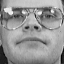

In [ ]:
im = Image.fromarray(images[359] * 256)
new_im = im.convert('RGB')

display(new_im)

# Решение

In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
from torchsummary import summary
import tqdm
from sklearn.metrics import classification_report

In [ ]:
class Loader(Dataset):

    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))
        ])
        self.data = torch.vstack([self.transform(i) for i in np.load("content/train/olivetti_faces.npy")]).unsqueeze(1)
        self.targets = torch.from_numpy(np.load("content/test/olivetti_faces_target.npy")).to(torch.long)
        self.n_classes = self.targets.unique().size(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    
dataset = Loader()

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [ ]:
data = torch.vstack([transform(i) for i in np.load("content/train/olivetti_faces.npy")]).unsqueeze(1)
targets = torch.from_numpy(np.load("content/test/olivetti_faces_target.npy")).to(torch.long)
n_classes = targets.unique().size(0)

In [ ]:
class Loader(Dataset):
    def __init__(self, data, targets, n_classes):
        self.data = data
        self.targets = targets
        self.n_classes = n_classes
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [ ]:
dataset = Loader(data, targets, n_classes)

In [ ]:
dataset.data.size()

torch.Size([400, 1, 64, 64])

In [ ]:
dataset.targets.size()

torch.Size([400])

In [ ]:
dataset.n_classes

40

In [ ]:
# отбираю 80%
torch.manual_seed(0)
train_size = round(0.80 * len(dataset))
test_size = len(dataset) - train_size

In [ ]:
# само разделение
train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))

In [ ]:
len(train_dataset), len(test_dataset)

(320, 80)

In [ ]:
class FacesNet(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(4096, 128), #дефолт размеры картинки
            nn.ReLU(),
            nn.Linear(128, n_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [ ]:
torch.manual_seed(0)

net = FacesNet(1, dataset.n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [ ]:
net.train()

FacesNet(
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=40, bias=True)
  )
)

In [ ]:
epochs = 150
for epoch in tqdm.tqdm(range(epochs)):
    for x, y in train_dataloader:
        pred = net(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.28it/s]


In [ ]:
net.eval()

FacesNet(
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=40, bias=True)
  )
)

In [ ]:
x_test, y_test = next(iter(test_dataloader))
y_pred = net(x_test).argmax(1)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       0.80      1.00      0.89         4
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         2
          19       1.00    